In [1]:
instance = 1

In [2]:
nlinks = 2

In [3]:
# setup
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# SYMBOLIC EQUATIONS FOR LHS OF GENERIC LINK --------------------------------------------------------------------------

# parameters
g = sym.symbols('g')
m = sym.symbols('m')
l = sym.symbols('l')
dtop = sym.symbols('d_t')
dbottom = sym.symbols('d_b')
I_phi = sym.symbols('I_{\\phi}')
I_psi = sym.symbols('I_{\\psi}')
I_th = sym.symbols('I_{\\theta}')

from sympy.algebras.quaternion import Quaternion

# coordinates
length = 0.5
X0 = 0
Y0 = 0
Z0 = length*(nlinks+1)

sym_angles = ['\\phi','\\psi','\\theta']
q_sym = sym.symbols(['%s_{%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
q = sym.Matrix(q_sym)

dq_sym = sym.symbols(['\\dot{%s}_{%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
dq = sym.Matrix(dq_sym)

ddq_sym = sym.symbols(['\\ddot{%s}_{%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
ddq = sym.Matrix(ddq_sym)

om_sym = sym.symbols(['\\omega_{%s%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
om = sym.Matrix(om_sym)

dom_sym = sym.symbols(['\\dot{\\omega}_{%s%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
dom = sym.Matrix(dom_sym)

# get rotation matrix ---------------------------------------------------------------------
order = ['z','y','x'] # rotation order
def get_Rsym(phi_in, psi_in, th_in, order): # generate rotation matrix
    Rx = sym.Matrix([[1,0,0],
                    [0,sym.cos(phi_in),-sym.sin(phi_in)],
                    [0,sym.sin(phi_in),sym.cos(phi_in)]])

    Ry = sym.Matrix([[sym.cos(psi_in),0,sym.sin(psi_in)],
                    [0,1,0],
                    [-sym.sin(psi_in),0,sym.cos(psi_in)]])

    Rz = sym.Matrix([[sym.cos(th_in),-sym.sin(th_in),0],
                    [sym.sin(th_in),sym.cos(th_in),0],
                    [0,0,1]])
    
    Rdict = {'x': Rx, 'y': Ry, 'z': Rz}
    
    R30 = Rdict[order[0]]*Rdict[order[1]]*Rdict[order[2]]
    
    # euler velocity matrix
    cols = {'x': sym.Matrix([[1],[0],[0]]), 'y': sym.Matrix([[0],[1],[0]]), 'z': sym.Matrix([[0],[0],[1]])}
    
    R23 = Rdict[order[2]].transpose()
    
    R13 = Rdict[order[2]].transpose()*Rdict[order[1]].transpose()
    
    R03 = R30.transpose()
    
    out_cols = {order[2]: R23*cols[order[2]], order[1]: R13*cols[order[1]], order[0]: R03*cols[order[0]]}
    
    Rvel = sym.Matrix([])
    Rvel = Rvel.col_insert(0,out_cols['x'])
    Rvel = Rvel.col_insert(1,out_cols['y'])
    Rvel = Rvel.col_insert(2,out_cols['z'])
    
    return [R, Rvel]

# COM positions ---------------------------------------------------------------------------------------------------------
top = {}
COMp = {}
bottom = {}

COMv = {}
omega = {}

top[1] = sym.Matrix([[X0],[Y0],[Z0]])
for i in range(1,nlinks+1):
    start = (i-1)*3
    R, Rvel = get_Rsym(q_sym[start],q_sym[start+1],q_sym[start+2],order)
    COMp[i] = top[i] - R*sym.Matrix([[0],[0],[dtop*l]])
    bottom[i] = top[i] - R*sym.Matrix([[0],[0],[l]])
    top[i+1] = bottom[i]
    
    COMv_ar = COMp[i].jacobian(q)*dq
    COMv[i] = sym.trigsimp(COMv_ar)

    omega[i] = Rvel*sym.Matrix([[dq_sym[start]],[dq_sym[start+1]],[dq_sym[start+2]]])

# energy -----------------------------------------------------------------------------------------------
T = sum([0.5*m*COMv[i][j]**2 for i in range(1,nlinks+1) for j in range(3)]) +\
    sum([0.5*I_phi*omega[i][0]**2 + 0.5*I_psi*omega[i][1]**2 + 0.5*I_th*omega[i][2]**2 for i in range(1,nlinks+1)])
    
V = sum([m*g*COMp[i][2] for i in range(1,nlinks+1)])

# partials of T and V 
# term 1
Lg1 = sym.zeros(len(q),1)
for i in range(len(q)):
    dT_ddq = sym.Matrix([sym.diff(T,dq[i])]) # get partial of T in dq_i
    p1 = dT_ddq.jacobian(q)*dq
    p2 = dT_ddq.jacobian(dq)*ddq
    Lg1[i] = p1 + p2 

# term 3
Lg3 = sym.Matrix([T]).jacobian(q).transpose() # partial of T in q

# term 4
Lg4 = sym.Matrix([V]).jacobian(q).transpose() # partial of V in q

# # generalized forces ----------------------------------------------------------------------------------------
tau_sym = sym.symbols(['\\tau_{%s%d}'%(a,i) for i in range(1,nlinks+1) for a in sym_angles])
tau = sym.Matrix(tau_sym)
Q = sym.zeros(len(q),1)
for i in range(1,nlinks+1):
    start = (i-1)*3
    torque = sym.Matrix([[tau[start]],[tau[start+1]],[tau[start+2]]])
    if i == 1:
        dW = torque.dot(omega[i])
    else:
        dW = torque.dot(omega[i] - omega[i-1])
    Q += sym.Matrix([dW]).jacobian(dq).transpose()

# # # combine ---------------------------------------------------------------------------------------------------
EOM = Lg1 - Lg3 + Lg4 - Q

In [5]:
# LAMBDIFY
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m,l,dtop,dbottom,I_phi,I_psi,I_th]+\
           q_sym + dq_sym + ddq_sym +\
           tau_sym
#            om_sym + dom_sym +\
#            tau_sym

lamb_EOM = {}
angles = ['phi','psi','th']
DOFs = [(i,a) for i in range(1,nlinks+1) for a in angles]
for dof_i, dof in enumerate(DOFs):
    lamb_EOM[dof] = sym.lambdify(sym_list,EOM[dof_i],modules = [func_map])
    
# lamb_er_to_omega = {}
# lamb_er_to_domega = {}
# angles = ['phi','psi','th']
# for l_i in range(1,nlinks+1):
#     for a_i, a in enumerate(angles):
#         lamb_er_to_omega[l_i,a] = sym.lambdify(sym_list,er_to_omega[l_i][a_i],modules = [func_map])
#         lamb_er_to_domega[l_i,a] = sym.lambdify(sym_list,er_to_domega[l_i][a_i],modules = [func_map])

lamb_top = {}
lamb_bottom = {}
for l_i in range(1,nlinks+1):
    for dof_i, dof in enumerate(['x','y','z']):
        lamb_top[l_i,dof] = sym.lambdify(sym_list,top[l_i][dof_i],modules = [func_map])
        lamb_bottom[l_i,dof] = sym.lambdify(sym_list,bottom[l_i][dof_i],modules = [func_map])


# Pyomo Model

In [6]:
def get_gauss_mat(k):
    # get polynomial
    x = sym.symbols('x')
    Legendre = sym.diff((x**2 - 1)**k,x,k)
    roots = sym.solve(Legendre,x)
    tv = np.sort([float(root) for root in roots])
    
    # get matrix
    t = sym.symbols('t')

    l = sym.zeros(k,1)
    L = sym.zeros(k,1) # antiderivative
    for i in range(k):
        num = sym.prod([t-tv[j] for j in range(k) if j != i])
        den = sym.prod([tv[i]-tv[j] for j in range(k) if j != i])
        exp = num/den
        l[i] = exp.expand()
        L[i] = sym.integrate(exp,t)

    Rmat = sym.zeros(k,k)
    for i in range(k):
        for j in range(k):
            Rmat[i,j] = 0.5*(L[j].subs(t,tv[i])-L[j].subs(t,-1))
            
    out_mat = np.zeros([k,k])
    for i in range(k):
        for j in range(k):
            out_mat[i][j] = Rmat.row(i)[j]
            
    # get weights
    scale = 1/(np.math.factorial(k)*2**k)
    weights = np.zeros(k)
    dP = sym.diff(scale*Legendre,x)
    for i, ti in enumerate(tv):
        weights[i] = 2/((1 - ti**2)*dP.subs(x,ti)**2)
        
    return [out_mat, weights]

def get_gauss_roots(k):
    # get polynomial
    x = sym.symbols('x')
    Legendre = sym.diff((x**2 - 1)**k,x,k)
    roots = sym.solve(Legendre,x)
    tv = np.sort([-1]+[float(root) for root in roots]+[1])
    tv = 0.5*tv + 0.5
    return tv

In [7]:
TDOFs = ['x','y','z']
angles = ['phi','psi','th']

# Parameters
mass = 0.1
length = 0.5

def get_var_list(m,n,p):
    var_list = [m.g,m.m[1],m.l[1],m.dCOM[1],-(1-m.dCOM[1])]+[m.I[1,a] for a in angles]+\
                [m.q[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]+\
                [m.dq[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]+\
                [m.ddq[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]+\
                [m.Ft[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]
#                 [m.omega[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]+\
#                 [m.domega[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]+\
#                 [m.Ft[n,p,l,dof] for l in range(1,nlinks+1) for dof in angles]
    return var_list

def create_model(N,P,hm):
    m = ConcreteModel()

    # SETS-----------------------------------------------------------------------------------------------------------------------
    m.N = RangeSet(N) 
    m.P = Set(initialize = range(P+2))
    m.L = RangeSet(nlinks)
    m.DOF = Set(initialize = angles) 
    m.A = Set(initialize = angles)
    
    # PARAMETERS-----------------------------------------------------------------------------------------------------------------

    m.g = Param(initialize = 9.81)
    m.m = Param(m.L, initialize = mass)
    m.dCOM = Param(m.L, initialize = 0.5)
    m.l = Param(m.L, initialize = length)
    
    def get_inertia(m,l,a):
        if a == 'th':
            r = 0.025
            return 0.5*m.m[l]*r**2
        else:
            return (m.m[l]*m.l[l]**2)/12.0
    m.I = Param(m.L, m.A, initialize = get_inertia)
    
    # VARIABLES -----------------------------------------------------------------------------------------------------------------

    # generalized coordinates
    m.q = Var(m.N, m.P, m.L, m.DOF) # position
    m.dq = Var(m.N, m.P, m.L, m.DOF) # velocity
    m.ddq = Var(m.N, m.P, m.L, m.DOF) # acceleration
    
#     m.omega = Var(m.N, m.P, m.L, m.A) # angular velocity
#     m.domega = Var(m.N, m.P, m.L, m.A) # angular acceleration
                    
    #TIME AND INTEGRATION ---------------------------------------------------------------------------------------------------

    # timestep
    m.hm = Param(initialize = hm, mutable = True) # master timestep
    m.h = Param(m.N, initialize = 1.0) 
    
    # Numerical integration ---------------------------------------------------------------------------------------------------
    col_mat, weights = get_gauss_mat(P)

    def integrate_p(m,n,p,l,dof):
        if p == 0: # continuity constraint:
            if n == 1: return Constraint.Skip
            return m.q[n,0,l,dof] == m.q[n-1,P+1,l,dof]
        if p > 0 and p < P+1:
            return m.q[n,p,l,dof] == m.q[n,0,l,dof] + m.hm*m.h[n]*sum([col_mat[p-1][pp-1]*m.dq[n,pp,l,dof] for pp in range(1,P+1)])
        if p == P+1:
            return m.q[n,p,l,dof] == m.q[n,0,l,dof] + 0.5*m.hm*m.h[n]*sum([weights[pp-1]*m.dq[n,pp,l,dof] for pp in range(1,P+1)])
    m.integrate_p = Constraint(m.N, m.P, m.L, m.DOF, rule = integrate_p)
    
    def integrate_v(m,n,p,l,dof):
        if p == 0: # continuity constraint:
            if n == 1: return Constraint.Skip
            return m.dq[n,0,l,dof] == m.dq[n-1,P+1,l,dof]
        if p > 0 and p < P+1:
            return m.dq[n,p,l,dof] == m.dq[n,0,l,dof] + m.hm*m.h[n]*sum([col_mat[p-1][pp-1]*m.ddq[n,pp,l,dof] for pp in range(1,P+1)])
        if p == P+1:
            return m.dq[n,p,l,dof] == m.dq[n,0,l,dof] + 0.5*m.hm*m.h[n]*sum([weights[pp-1]*m.ddq[n,pp,l,dof] for pp in range(1,P+1)])
    m.integrate_v = Constraint(m.N, m.P, m.L, m.DOF, rule = integrate_v)

    # DYNAMICS ----------------------------------------------------------------------------------------------------------------
    m.Ft = Var(m.N, m.P, m.L, m.A)
    m.sgn = Set(initialize = ['ps','ng'])
    m.epsilon = Var(m.N, m.P, m.L, m.A, m.sgn, bounds = (0,None))
    
    def dynamics(m,n,p,l,dof):
        if p == 0 or p == P+1: return Constraint.Skip
        var_list = get_var_list(m,n,p)
        return lamb_EOM[(l,dof)](*var_list) == m.epsilon[n,p,l,dof,'ps']-m.epsilon[n,p,l,dof,'ng']
    m.dynamics = Constraint(m.N, m.P, m.L, m.DOF, rule = dynamics)
            
     
    # OBJECTIVE ----------------------------------------------------------------------------------------------------------
    
    def MinEffort(m):
        feas = sum([m.epsilon[n,p,l,dof,sgn]**2 for n in range(1,N+1) for p in range(P+2) for l in range(1,nlinks+1) for dof in angles for sgn in ['ps','ng']])
        obj = sum([m.Ft[n,p,l,a]**2 for n in range(1,N+1) for p in range(1,P+1) for l in range(2,nlinks+1) for a in angles])
        return 1000*feas + obj
    m.MinEffort = Objective(rule = MinEffort)

        
    # TASK ---------------------------------------------------------------------------------------------------------------
    for n in range(1,N+1):
        for p in range(P+2):
            for a in angles:
                m.Ft[n,p,1,a].fix(0)
    
    # swing-up                    
    for l in range(1,nlinks+1):
        for a in angles:
#             m.omega[1,0,l,a].fix(0)
            m.dq[1,0,l,a].fix(0)
    
    # initial
    for l in range(1,nlinks+1):
        m.q[1,0,l,'phi'].fix(0)
        m.q[1,0,l,'psi'].fix(0)
        m.q[1,0,l,'th'].fix(0)
      
  # final
    for l in range(1,nlinks+1):
        m.q[N,P+1,l,'phi'].fix(np.pi)
        m.q[N,P+1,l,'psi'].fix(0)
        m.q[N,P+1,l,'th'].fix(0)

#     for l in range(1,nlinks+1):
#         for dof in ['x','y']:
#             m.q[N,P+1,l,dof].fix(0)
#         m.q[N,P+1,l,'z'].setlb(Z0)
        
    for l in range(1,nlinks+1):
        for a in angles:
            m.dq[N,P+1,l,a].fix(0)
#             m.omega[N,P+1,l,a].fix(0)
        
#     # unactuated drop
#     for n in range(1,N+1):
#         for p in range(P+2):
#             for l in range(1,nlinks+1):
#                 for a in angles:
#                     m.Ft[n,p,l,a].fix(0)
                    
#     for l in range(1,nlinks+1):
#         for a in angles:
#             m.dq[1,0,l,a].fix(0)
# #             m.omega[1,0,l,a].fix(0)
    
#     for l in range(1,nlinks+1):
#         m.q[1,0,l,'phi'].fix(np.pi/2)
#         m.q[1,0,l,'psi'].fix(0)
#         m.q[1,0,l,'th'].fix(0)
        
    # angles
    for n in range(1,N+1):
        for p in range(P+2):
            for l in range(1,nlinks+1):
                for a in angles:
                    m.q[n,p,l,a].setlb(-2*np.pi)
                    m.q[n,p,l,a].setub(2*np.pi)

            
    return m

# Utilities

In [8]:
def init_opt(): # initializes solver
    opt = SolverFactory('ipopt',executable = r'/usr/local/bin/ipopt')
    opt.options["linear_solver"] = 'ma97'
    opt.options["print_level"] = 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
    opt.options["max_iter"] = 30000 # maximum number of iterations
    opt.options["max_cpu_time"] = 1e5 # maximum cpu time in seconds
    opt.options["tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.
    
#     opt.options["Tol"] = 1e-4
    
    opt.options["OF_acceptable_obj_change_tol"] = 1e-4
    opt.options["OF_ma86_scaling"] = 'none'
    
    return opt

In [9]:
def check_model(m,result):
    if result.solver.status != SolverStatus.ok:
        print('fail: solver not ok')
        return 0
    if result.solver.termination_condition != TerminationCondition.optimal:
        print('fail: did not find optimal solution')
        return 0
    return 1

In [10]:
import pickle as pickle

def save_model(m,solvetime,outname):

    outfile = open(outname,'wb')
    data = {}
    
    data = {'N':N, 'P':P, 'hm':hm, 'coltype': 'gauss'}
    
    cost = sum([m.Ft[n,p,l,dof].value**2 for n in range(1,N+1) for p in range(1,P+1) for l in range(2,nlinks+1) for dof in angles])
     
    max_penalty = np.max([m.epsilon[n,p,l,dof,sgn].value for n in range(1,N+1) for p in range(1,P+1) for l in range(1,nlinks+1) for dof in angles for sgn in ['ps','ng']])
    data['max_penalty'] = max_penalty
        
    data.update({'cost':cost})
    data.update({'solvetime':solvetime})
    
    for l in range(1,nlinks+1):
        data.update({('m',l): m.m[l]})
        data.update({('l',l): m.l[l]})
        for a in angles:
            data.update({('I',l,a): m.I[l,a]})
    
    if P == 1:
        tau = [0,1,1]
    else:
        tau = get_gauss_roots(P)
    
    for n in range(1,N+1):
        data.update({('h',n):m.hm.value*m.h[n]})
        for p in range(P+2):
            t0 = np.array([sum([hm*m.h[nn] for nn in range(1,n)]) for n in range(1,N+1)])
         
            data.update({('h',n): m.h[n]})
            data.update({('tau',n,p): tau[p]})
            data.update({('time',n,p): t0[n-1] + hm*m.h[n]*tau[p]})
            
            for l in range(1,nlinks+1):
                for dof in angles:
                    data.update({('q',n,p,l,dof):m.q[n,p,l,dof].value})
                    data.update({('dq',n,p,l,dof):m.dq[n,p,l,dof].value})
                    data.update({('ddq',n,p,l,dof):m.ddq[n,p,l,dof].value})
                    data.update({('Ft',n,p,l,dof):m.Ft[n,p,l,dof].value})

    pickle.dump(data,outfile)
    outfile.close()
    return data

In [11]:
from time import time

def solve_model(m):
    opt = init_opt()
    success = 0
    try:
        t1 = time()
        result = opt.solve(m,tee = False)
        t2 = time()
        solvetime = t2-t1
        opt_time = 0
        success = check_model(m,result)
    except:
        print('fail')
        result = 0
        solvetime = 0
    
    if success > 0:
        print('success')
        
    return [m,result,success,solvetime]

# Solve Loop

In [12]:
# P = 4
# T = 1.0
# N = int(100/P)
# hm = T/N

# minit = create_model(N,P,hm)
# # minit.MinEffort.deactivate()

# opt = init_opt()
# results = opt.solve(minit, tee = True)

In [13]:
P = 4
T = 1.0
N = int(100/P)
hm = T/N

seeds = 1
for sd in range(seeds):
    m = create_model(N,P,hm)
    
#     for n in range(1,N+1):
#         for p in range(P+2):
#             for l in range(1,nlinks+1):
#                 for dof in angles:
#                     for sgn in ['ps','ng']:
#                         m.epsilon[n,p,l,dof,sgn].fix(0)
    
#     for n in range(1,N+1):
#         for p in range(1,P+1):
#             for l in range(1,nlinks+1):
#                 for a in angles:
#                     m.q[n,p,l,a].value = minit.q[n,p,l,a].value + np.random.uniform(-0.1,0.1)
    
    print('ATTEMPT %d'%sd)
    m, result, success, solvetime = solve_model(m)
    if success > 0:
        filename = r'pendulum3D_results/pendulum3D_%d_RTAO_i%dsd%d_NULL'%(nlinks,instance,sd)
        save_model(m,solvetime,filename)


ATTEMPT 0
success


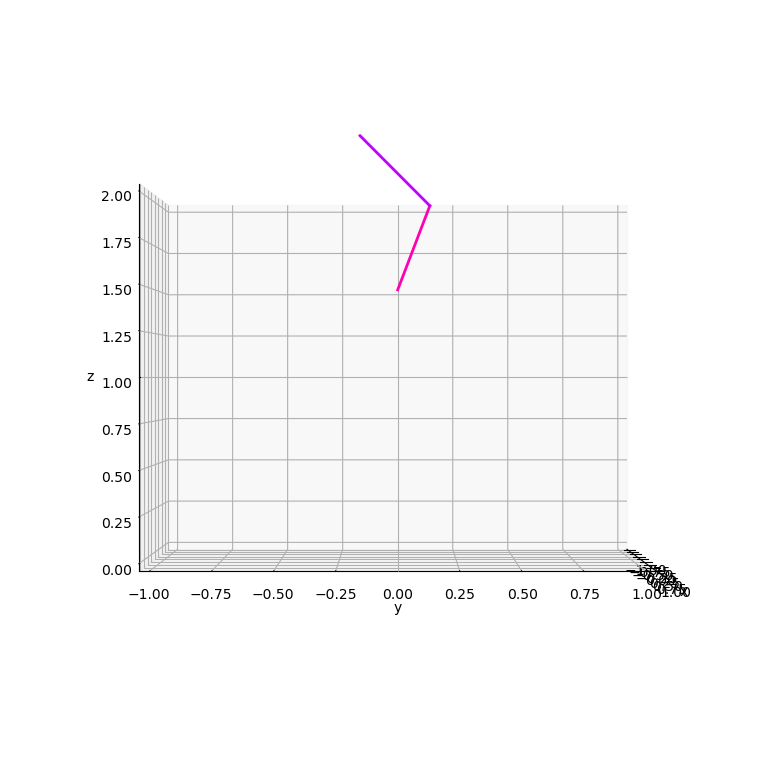

In [14]:
#animate it
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
import numpy as np
import quaternion as qn
%matplotlib inline

p=0
poi = 0

fig = plt.figure(figsize = [10,10],dpi=100)
ax = fig.add_subplot(111, projection='3d')

links = range(1,nlinks+1)

cols = ['xkcd:bright pink',
        'xkcd:bright purple',
        'xkcd:blue',
        'xkcd:bright blue',
        'xkcd:teal',
        'xkcd:bright green',
        'xkcd:yellow',
        'xkcd:orange',
        'xkcd:red',
        'xkcd:bright pink']

def plot_model(n): #update function for animation
    ax.clear()
    ax.set_xlim([-nlinks*length,nlinks*length])
    ax.set_ylim([-nlinks*length,nlinks*length])
    ax.set_zlim([0,2*nlinks*length])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.view_init(0,0)
    
    p = 0
    
    var_list = [m.g,m.m[1],m.l[1],m.dCOM[1],-(1-m.dCOM[1])]+[m.I[1,a] for a in angles]+\
                [m.q[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]+\
                [m.dq[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]+\
                [m.ddq[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]+\
                [m.Ft[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]
#                 [m.omega[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]+\
#                 [m.domega[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]+\
#                 [m.Ft[n,p,l,dof].value for l in range(1,nlinks+1) for dof in angles]

    for l in range(1,nlinks+1):
        top = {}
        bottom = {}
        for dof in ['x','y','z']:
            top[dof] = lamb_top[l,dof](*var_list)
            bottom[dof] = lamb_bottom[l,dof](*var_list)
            
        ax.plot([top['x'], bottom['x']],
                [top['y'], bottom['y']],
                [top['z'], bottom['z']],
                linewidth=2,color = cols[l-1],zorder=100)
        
animate = ani.FuncAnimation(fig,plot_model,range(1,N+1),interval = 50,repeat=True)
HTML(animate.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook
